In [36]:
import librosa.display
from glob import glob
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image
import json
import matplotlib.pyplot as plt

In [37]:
DIR = "ESC-50"
files = glob(f"{DIR}/**/*.wav", recursive=True)
n_fft = 2048
hop_length = 128

In [38]:
labels = []
db_lost_cutoff = []
cutoff_percent_lost = []
db_differences_original = []

CUTOFF = -63.22
for file in tqdm(files):
    signal, sr = librosa.load(file)  # Get signal and sample-rate

    """Get class and file name elements."""
    file_name = file.split("/")[-1].split(".")[0]
    *_, cl = file_name.split("-")

    """Generate MEL-Spectrogram and transform it to db."""
    mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, window="hann", hop_length=hop_length, n_fft=n_fft)
    spectrogram = np.abs(mel_signal)
    power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
    
    """
    Since these audio recordings are all multiple seconds long we can split them to have more data.
    Additionally we avoid loosing a substantial amount of information with cutoffs.
    
    The approach is as follows: we take windows of 128 size from the recording and split the audio.
    A small cutoff at the end will be lost (This cutoff is constant since all .wav files have the same length). 
    
    Note that some parts of the audio files is quiet with no sound. 
    To avoid having segments with no or minimal audio we discard some based on a cutoff.
    The cutoff is based on the mean dB measure in all spectrograms, which is -49.
    We substract one std of 14.22 from this value to get the cutoff threshold.
    """
    num_elems = power_to_db.shape[1] // 128  # Check the number of elements to be cut.
    
    cutoff_percent_lost.append(num_elems*128/power_to_db.shape[1])  # Measure the amount of lost information.
    db_lost_cutoff.append(np.mean(power_to_db[:,num_elems*128:]))  # Measure the average dB amount lost by the cutoff.
    
    cut_spectrograms = np.split(power_to_db[:,:num_elems*128], num_elems, axis=1)
    mean_db_original = np.mean(power_to_db)
    for i, elem in enumerate(cut_spectrograms):
        if np.mean(elem) < CUTOFF:  # If the segment is too empty we skip it.
            continue
        db_differences_original.append(np.mean(elem)/mean_db_original)  # Check the mean dB difference between segment and original.
        
        """Save image and label map."""
        img = Image.fromarray(elem.astype("uint8"))
        rel_path = f"img/{file_name}_{i}.png"
        img.save(f"{DIR}/{rel_path}")
        labels.append([rel_path, int(cl)])

"""Save dataset map with labels."""
with open(f"{DIR}/dataset.json", "w") as f:
    json.dump({"labels": labels}, f) 

  0%|          | 0/2000 [00:00<?, ?it/s]

Generated 9683 spectrograms, from 2000 audio files. A 484.15% change.
On average -52.76 dB were cutoff from the data.
The cutoff was 10.90% of the original spectrogram on average.
The smaller spectrograms are on average 8.30% different to the original wrt. dB.


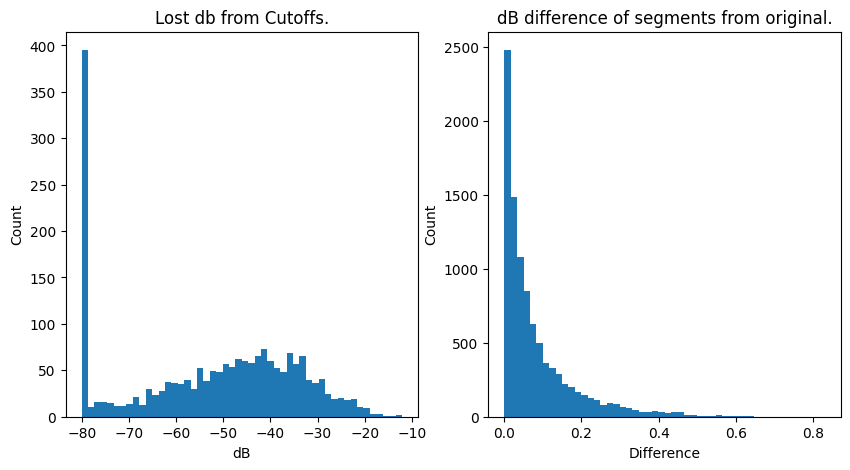

In [63]:
print(f"Generated {(ll := len(labels))} spectrograms, from {(lf := len(files))} audio files. A {ll/lf:.2%} change.")
print(f"On average {np.mean(db_lost_cutoff):.2f} dB were cutoff from the data.")
print(f"The cutoff was {1-np.mean(cutoff_percent_lost):.2%} of the original spectrogram on average.")
print(f"The smaller spectrograms are on average {np.mean(dbda := np.abs(np.array(db_differences_original)-1)):.2%} different to the original wrt. dB.")

fig, ax = plt.subplots(1,2, figsize=(10,5))
_ = ax[0].hist(db_lost_cutoff, bins=50)
ax[0].set_title("Lost db from Cutoffs.")
ax[0].set_xlabel("dB")
_ = ax[0].set_ylabel("Count")

_ = ax[1].hist(dbda, bins=50)
ax[1].set_title("dB difference of segments from original.")
ax[1].set_xlabel("Difference")
_ = ax[1].set_ylabel("Count")

"""As you can see from the first figure, most of the cutoff regions did not have any sound in them."""